In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
from time import perf_counter

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from torch.nn import GELU
from torch.optim import Adam
from tqdm.notebook import tqdm

from NCP.cde_fork.density_simulation import ArmaJump, EconDensity, GaussianMixture, LinearGaussian, SkewNormal
from NCP.cdf import compute_marginal, integrate_pdf, smooth_cdf
from NCP.examples.tools.data_gen import LGGMD
from NCP.metrics import kolmogorov_smirnov
from NCP.models.ncp import NCPModule, NCPOperator
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.mysc.utils import FastTensorDataLoader, from_np

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [3]:
from matplotlib.ticker import FormatStrFormatter

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7
}

plt.rcParams.update(tex_fonts)

In [4]:
# Class for preventing the wall of text
class LitProgressBar(L.pytorch.callbacks.TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True,)
        return bar

    def init_train_tqdm(self):
        bar = tqdm()
        bar.dynamic_ncols = False
        bar.ncols = 0
        bar.bar_format ='{desc} [{rate_fmt}{postfix}]'
        return bar

In [5]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint


class MyEarlyStopping(EarlyStopping):
    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer)

class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)
        torch.save(trainer.model.model, trainer.checkpoint_callback.dirpath + '/best_model.pt')

## Linear gaussian

In [6]:
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

from math import sqrt

sigma_sq = .1
density = LinearGaussian(**{'ndim_x': 1, 'std': 0.1, 'random_seed': 42})
p_x = lambda x: (1/sqrt(2*np.pi)) * np.exp(-(x**2)/2)
p_y = lambda y: (1/(sqrt(2*np.pi)*sqrt(1+sigma_sq))) * np.exp(-(y**2)/(2*(1+sigma_sq)))

X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

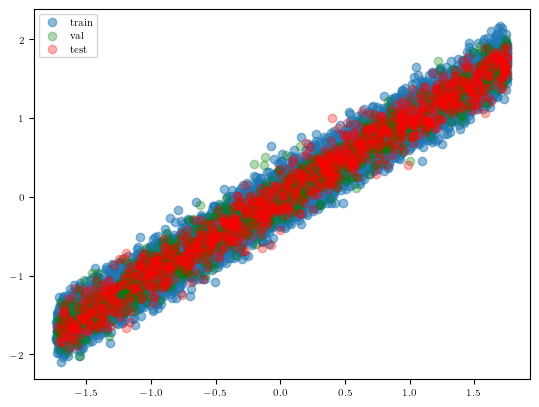

In [7]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [8]:
for seed in range(5):
    if os.path.isfile('models/NCP_LG_{0}.pt'.format(seed)):
        print('Model already trained')
        continue

    L.seed_everything(seed)

    lr = 1e-3
    gamma = 1e-3
    epochs = int(1e4)

    MLP_kwargs = {
        'input_shape': X_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'cov',
        'gamma': gamma
    }

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    ckpt_path = "checkpoints/NCP"
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

    logger_path = "lightning_logs/NCP"
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    trainer = L.Trainer(**{
        'accelerator': 'auto',
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 10,
        'enable_model_summary': True,
    }, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

    start = perf_counter()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    print(f'Training time: {perf_counter()-start}')

    best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
    print(checkpoint_callback.best_model_path)
    torch.save(best_model, 'models/NCP_LG_{0}.pt'.format(seed))

Model already trained
Model already trained
Model already trained
Model already trained
Model already trained


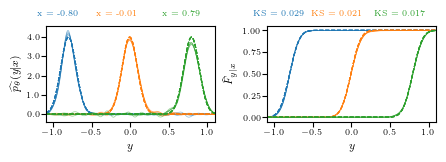

In [10]:
x_grid = np.percentile(X_train, [10, 50, 90])
p1, p99 = np.percentile(Y_train, [0.5, 99.5])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = from_np(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.5,1.5))
axes = ax.flatten()
postprocess = 'whitening'

models = [torch.load('models/NCP_LG_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
KS = np.zeros((len(x_grid),len(models)))
for i, xi in enumerate(x_grid):
    for j, model in enumerate(models):
        xi = xi.reshape(1, -1)
        fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
        fys = fys.reshape(-1, 1)
        true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[0].plot(yscaler.inverse_transform(fys), true_pdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[0].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_, color=colours[i],linewidth=0.5, alpha=0.5)

        pred_cdf = integrate_pdf(pred_pdf, ys)
        true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[1].plot(yscaler.inverse_transform(fys), true_cdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf), color=colours[i], linewidth=0.5, alpha=0.5)

        KS[i,j] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

KS = KS.mean(axis=1)
x_transformed = xscaler.inverse_transform(x_grid.reshape(-1, 1)).squeeze()
y_pos = axes[0].get_ylim()[1] +0.3
x_pos = np.array([.18, .31, .45])
for i in range(len(x_grid)):
    fig.text(x_pos[i], 0.98, r'x = {0:.2f}'.format(x_transformed[i]), ha="right", va="bottom", size=6, color=colours[i])

y_pos = axes[1].get_ylim()[1] +0.1
for i in range(len(x_grid)):
    fig.text(x_pos[i]+0.5, 0.98, r'KS = {0:.3f}'.format(KS[i]), ha="right", va="bottom",size=6, color=colours[i])

axes[0].set_xmargin(0)
axes[0].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
axes[0].set_xlabel("$y$")
axes[0].tick_params(axis="x", pad=2, labelsize=6)
axes[0].tick_params(axis="y", pad=1, labelsize=6)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].set_xmargin(0)
axes[1].set_ylabel(r"$\widehat{F}_{y|x}$")
axes[1].set_xlabel("$y$")
axes[1].tick_params(axis="x", pad=2, labelsize=6)
axes[1].tick_params(axis="y", pad=1, labelsize=6)

plt.tight_layout()
plt.show()

## ECON 

In [11]:
sigma_sq = 1
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

density = EconDensity(std= sigma_sq, heteroscedastic=True, random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

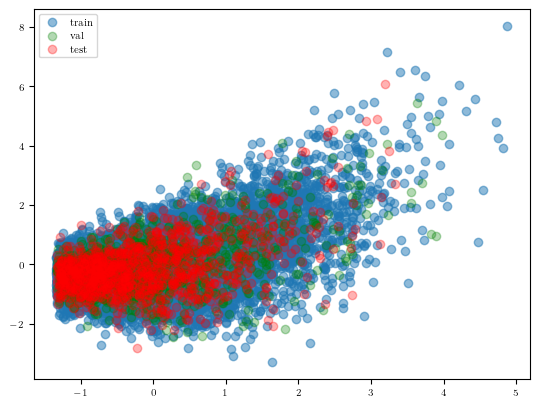

In [12]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [13]:
for seed in range(5):
    if os.path.isfile('models/NCP_ECON_{0}.pt'.format(seed)):
        print('Model already trained')
        continue

    L.seed_everything(seed)

    lr = 1e-3
    gamma = 1e-3
    epochs = int(1e4)

    MLP_kwargs = {
        'input_shape': X_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'cov',
        'gamma': gamma
    }

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    ckpt_path = "checkpoints/NCP/ECON"
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

    logger_path = "lightning_logs/NCP/ECON"
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    trainer = L.Trainer(**{
        'accelerator': 'auto',
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 10,
        'enable_model_summary': True,
    }, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

    start = perf_counter()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    print(f'Training time: {perf_counter()-start}')

    best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
    print(checkpoint_callback.best_model_path)
    torch.save(best_model, 'models/NCP_ECON_{0}.pt'.format(seed))

Model already trained
Model already trained
Model already trained
Model already trained
Model already trained


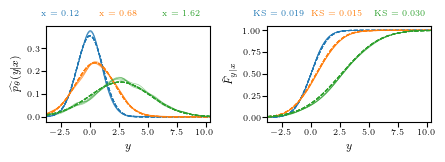

In [14]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, [10, 50, 90])
p1, p99 = np.percentile(Y_train, [0.5, 99.5])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = from_np(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.5,1.5))
axes = ax.flatten()
postprocess = 'whitening'

models = [torch.load('models/NCP_ECON_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
KS = np.zeros((len(x_grid),len(models)))
for i, xi in enumerate(x_grid):
    for j, model in enumerate(models):
        xi = xi.reshape(1, -1)
        fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
        fys = fys.reshape(-1, 1)
        true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[0].plot(yscaler.inverse_transform(fys), true_pdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[0].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_, color=colours[i],linewidth=0.5, alpha=0.5)

        pred_cdf = integrate_pdf(pred_pdf, ys)
        true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[1].plot(yscaler.inverse_transform(fys), true_cdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf), color=colours[i], linewidth=0.5, alpha=0.5)

        KS[i,j] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

KS = KS.mean(axis=1)
x_transformed = xscaler.inverse_transform(x_grid.reshape(-1, 1)).squeeze()
y_pos = axes[0].get_ylim()[1] +0.3
x_pos = np.array([.18, .31, .45])
for i in range(len(x_grid)):
    fig.text(x_pos[i], 0.98, r'x = {0:.2f}'.format(x_transformed[i]), ha="right", va="bottom", size=6, color=colours[i])

y_pos = axes[1].get_ylim()[1] +0.1
for i in range(len(x_grid)):
    fig.text(x_pos[i]+0.5, 0.98, r'KS = {0:.3f}'.format(KS[i]), ha="right", va="bottom",size=6, color=colours[i])

axes[0].set_xmargin(0)
axes[0].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
axes[0].set_xlabel("$y$")
axes[0].tick_params(axis="x", pad=2, labelsize=6)
axes[0].tick_params(axis="y", pad=1, labelsize=6)

axes[1].set_xmargin(0)
axes[1].set_ylabel(r"$\widehat{F}_{y|x}$")
axes[1].set_xlabel("$y$")
axes[1].tick_params(axis="x", pad=2, labelsize=6)
axes[1].tick_params(axis="y", pad=1, labelsize=6)

plt.tight_layout()
plt.show()

## ARMA Jump 

In [15]:
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

density = ArmaJump(random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
# shuffle the dataset
idx = np.random.permutation(len(X))
X, Y = X[idx], Y[idx]
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

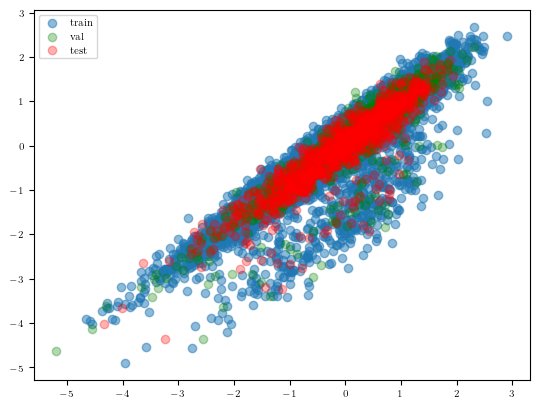

In [16]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [17]:
for seed in range(5):
    if os.path.isfile('models/NCP_ARMA_{0}.pt'.format(seed)):
        print('Model already trained')
        continue
    L.seed_everything(seed)

    lr = 1e-3
    gamma = 1e-3
    epochs = int(1e4)

    MLP_kwargs = {
        'input_shape': X_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'cov',
        'gamma': gamma
    }

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    ckpt_path = "checkpoints/NCP/ARMA"
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

    logger_path = "lightning_logs/NCP/ARMA"
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    trainer = L.Trainer(**{
        'accelerator': 'auto',
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 10,
        'enable_model_summary': True,
    }, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

    start = perf_counter()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    print(f'Training time: {perf_counter()-start}')

    best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
    print(checkpoint_callback.best_model_path)
    torch.save(best_model, 'models/NCP_ARMA_{0}.pt'.format(seed))

Model already trained
Model already trained
Model already trained
Model already trained
Model already trained


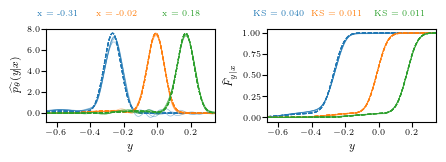

In [18]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, [10, 50, 90])
p1, p99 = np.percentile(Y_train, [0.5, 99.5])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = from_np(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.5,1.5))
axes = ax.flatten()
postprocess = 'whitening'

models = [torch.load('models/NCP_ARMA_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
KS = np.zeros((len(x_grid),len(models)))
for i, xi in enumerate(x_grid):
    for j, model in enumerate(models):
        xi = xi.reshape(1, -1)
        fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
        fys = fys.reshape(-1, 1)
        true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[0].plot(yscaler.inverse_transform(fys), true_pdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[0].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_, color=colours[i],linewidth=0.5, alpha=0.5)

        pred_cdf = integrate_pdf(pred_pdf, ys)
        true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[1].plot(yscaler.inverse_transform(fys), true_cdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf), color=colours[i], linewidth=0.5, alpha=0.5)

        KS[i,j] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

KS = KS.mean(axis=1)
x_transformed = xscaler.inverse_transform(x_grid.reshape(-1, 1)).squeeze()
y_pos = axes[0].get_ylim()[1] +0.3
x_pos = np.array([.18, .31, .45])
for i in range(len(x_grid)):
    fig.text(x_pos[i], 0.98, r'x = {0:.2f}'.format(x_transformed[i]), ha="right", va="bottom", size=6, color=colours[i])

y_pos = axes[1].get_ylim()[1] +0.1
for i in range(len(x_grid)):
    fig.text(x_pos[i]+0.5, 0.98, r'KS = {0:.3f}'.format(KS[i]), ha="right", va="bottom",size=6, color=colours[i])

axes[0].set_xmargin(0)
axes[0].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
axes[0].set_xlabel("$y$")
axes[0].tick_params(axis="x", pad=2, labelsize=6)
axes[0].tick_params(axis="y", pad=1, labelsize=6)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].set_xmargin(0)
axes[1].set_ylabel(r"$\widehat{F}_{y|x}$")
axes[1].set_xlabel("$y$")
axes[1].tick_params(axis="x", pad=2, labelsize=6)
axes[1].tick_params(axis="y", pad=1, labelsize=6)

plt.tight_layout()
plt.show()

## SkewNormal

In [19]:
density = SkewNormal(random_seed=0)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

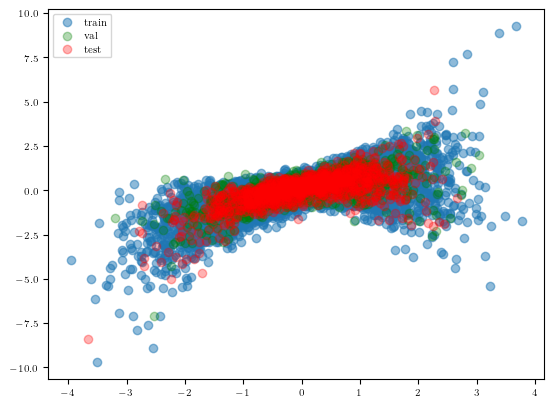

In [20]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [21]:
for seed in range(5):
    if os.path.isfile('models/NCP_SKEW_{0}.pt'.format(seed)):
        print('Model already trained')
        continue
    L.seed_everything(seed)

    lr = 1e-3
    gamma = 1e-3
    epochs = int(1e4)

    MLP_kwargs = {
        'input_shape': X_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'cov',
        'gamma': gamma
    }

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    ckpt_path = "checkpoints/NCP/SKEW"
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

    logger_path = "lightning_logs/NCP/SKEW"
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    trainer = L.Trainer(**{
        'accelerator': 'auto',
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 10,
        'enable_model_summary': True,
    }, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

    start = perf_counter()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    print(f'Training time: {perf_counter()-start}')

    best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
    print(checkpoint_callback.best_model_path)
    torch.save(best_model, 'models/NCP_SKEW_{0}.pt'.format(seed))

Model already trained
Model already trained
Model already trained
Model already trained
Model already trained


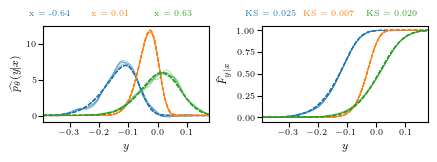

In [22]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, [10, 50, 90])
p1, p99 = np.percentile(Y_train, [0.5, 99.5])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = from_np(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.5,1.5))
axes = ax.flatten()
postprocess = 'whitening'

models = [torch.load('models/NCP_SKEW_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
KS = np.zeros((len(x_grid),len(models)))
for i, xi in enumerate(x_grid):
    for j, model in enumerate(models):
        xi = xi.reshape(1, -1)
        fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
        fys = fys.reshape(-1, 1)
        true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[0].plot(yscaler.inverse_transform(fys), true_pdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[0].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_, color=colours[i],linewidth=0.5, alpha=0.5)

        pred_cdf = integrate_pdf(pred_pdf, ys)
        true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[1].plot(yscaler.inverse_transform(fys), true_cdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf), color=colours[i], linewidth=0.5, alpha=0.5)

        KS[i,j] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

KS = KS.mean(axis=1)
x_transformed = xscaler.inverse_transform(x_grid.reshape(-1, 1)).squeeze()
y_pos = axes[0].get_ylim()[1] +0.3
x_pos = np.array([.18, .31, .45])
for i in range(len(x_grid)):
    fig.text(x_pos[i], 0.98, r'x = {0:.2f}'.format(x_transformed[i]), ha="right", va="bottom", size=6, color=colours[i])

y_pos = axes[1].get_ylim()[1] +0.1
for i in range(len(x_grid)):
    fig.text(x_pos[i]+0.5, 0.98, r'KS = {0:.3f}'.format(KS[i]), ha="right", va="bottom",size=6, color=colours[i])

axes[0].set_xmargin(0)
axes[0].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
axes[0].set_xlabel("$y$")
axes[0].tick_params(axis="x", pad=2, labelsize=6)
axes[0].tick_params(axis="y", pad=1, labelsize=6)

axes[1].set_xmargin(0)
axes[1].set_ylabel(r"$\widehat{F}_{y|x}$")
axes[1].set_xlabel("$y$")
axes[1].tick_params(axis="x", pad=2, labelsize=6)
axes[1].tick_params(axis="y", pad=1, labelsize=6)

plt.tight_layout()
plt.show()

## Gaussian Mixture

In [23]:
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

ndim_x = 1
ndim_y = 1
density = GaussianMixture(ndim_x=ndim_x, ndim_y=ndim_y, means_std=3, random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape(-1, 1)
if Y.ndim == 1:
    Y = Y.reshape(-1, 1)
X_train, X_val, Y_train, Y_val = X[:Ntrain,:], X[-Nval:,:], Y[:Ntrain,:], Y[-Nval:,:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)
if Y_test.ndim == 1:
    Y_test = Y_test.reshape(-1, 1)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

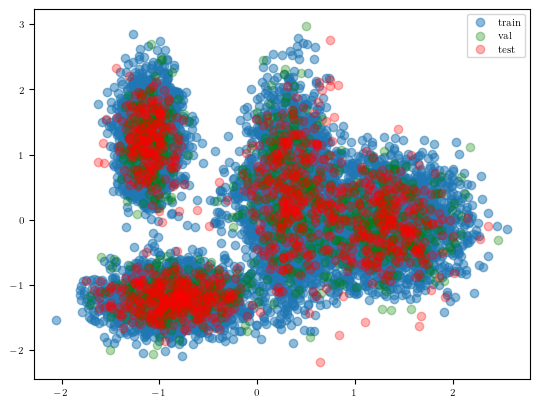

In [24]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [25]:
for seed in range(5):
    if os.path.isfile('models/NCP_GMM_{0}.pt'.format(seed)):
        print('Model already trained')
        continue
    L.seed_everything(seed)

    lr = 1e-3
    gamma = 1e-3
    epochs = int(1e4)

    MLP_kwargs = {
        'input_shape': X_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'cov',
        'gamma': gamma
    }

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    ckpt_path = "checkpoints/NCP/GMM"
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

    logger_path = "lightning_logs/NCP/GMM"
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    trainer = L.Trainer(**{
        'accelerator': 'auto',
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 10,
        'enable_model_summary': True,
    }, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

    start = perf_counter()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    print(f'Training time: {perf_counter()-start}')

    best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
    print(checkpoint_callback.best_model_path)
    torch.save(best_model, 'models/NCP_GMM_{0}.pt'.format(seed))

Model already trained
Model already trained
Model already trained
Model already trained
Model already trained


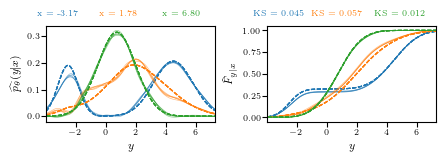

In [26]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, [10, 50, 90])
p1, p99 = np.percentile(Y_train, [0.5, 99.5])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = from_np(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.5,1.5))
axes = ax.flatten()
postprocess = 'whitening'

models = [torch.load('models/NCP_GMM_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
KS = np.zeros((len(x_grid),len(models)))
for i, xi in enumerate(x_grid):
    for j, model in enumerate(models):
        xi = xi.reshape(1, -1)
        fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
        fys = fys.reshape(-1, 1)
        true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                               yscaler.inverse_transform(ys)).squeeze()
        axes[0].plot(yscaler.inverse_transform(fys), true_pdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[0].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_, color=colours[i],linewidth=0.5, alpha=0.5)

        pred_cdf = integrate_pdf(pred_pdf, ys)
        true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)), yscaler.inverse_transform(ys)).squeeze()
        axes[1].plot(yscaler.inverse_transform(fys), true_cdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf), color=colours[i], linewidth=0.5, alpha=0.5)

        KS[i,j] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

KS = KS.mean(axis=1)
x_transformed = xscaler.inverse_transform(x_grid.reshape(-1, 1)).squeeze()
y_pos = axes[0].get_ylim()[1] +0.3
x_pos = np.array([.18, .31, .45])
for i in range(len(x_grid)):
    fig.text(x_pos[i], 0.98, r'x = {0:.2f}'.format(x_transformed[i]), ha="right", va="bottom", size=6, color=colours[i])

y_pos = axes[1].get_ylim()[1] +0.1
for i in range(len(x_grid)):
    fig.text(x_pos[i]+0.5, 0.98, r'KS = {0:.3f}'.format(KS[i]), ha="right", va="bottom",size=6, color=colours[i])

axes[0].set_xmargin(0)
axes[0].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
axes[0].set_xlabel("$y$")
axes[0].tick_params(axis="x", pad=2, labelsize=6)
axes[0].tick_params(axis="y", pad=1, labelsize=6)

axes[1].set_xmargin(0)
axes[1].set_ylabel(r"$\widehat{F}_{y|x}$")
axes[1].set_xlabel("$y$")
axes[1].tick_params(axis="x", pad=2, labelsize=6)
axes[1].tick_params(axis="y", pad=1, labelsize=6)

plt.tight_layout()
plt.show()

## LGGMD

In [27]:
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

ndim_x = 20
ndim_y = 1
density = LGGMD(random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1)
X_train, X_val, Y_train, Y_val = X[:Ntrain,:], X[-Nval:,:], Y[:Ntrain,:], Y[-Nval:,:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

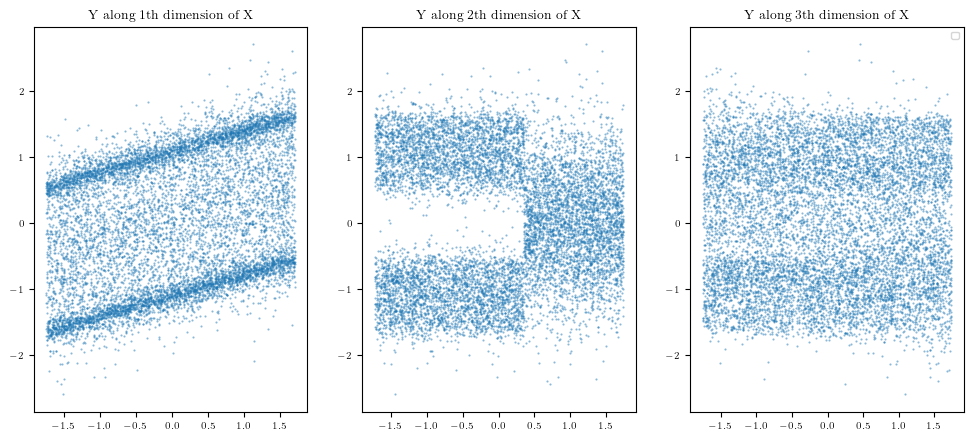

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.5, s=0.3)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])

plt.show()

In [29]:
for seed in range(5):
    if os.path.isfile('models/NCP_LGGMD_{0}.pt'.format(seed)):
        print('Model already trained')
        continue
    L.seed_everything(seed)

    lr = 1e-3
    gamma = 1e-3
    epochs = int(1e4)

    U_kwargs = {
        'input_shape': X_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }

    V_kwargs = {
        'input_shape': Y_train.shape[-1],
        'output_shape': 100,
        'n_hidden': 2,
        'layer_size': [64,64],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': GELU
    }


    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'cov',
        'gamma': gamma
    }

    NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=U_kwargs, V_operator_kwargs=V_kwargs)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    NCP_module = NCPModule(
        NCP_model,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    ckpt_path = "checkpoints/NCP/LGGMD"
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

    logger_path = "lightning_logs/NCP/LGGMD"
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    trainer = L.Trainer(**{
        'accelerator': 'auto',
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 10,
        'enable_model_summary': True,
    }, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

    start = perf_counter()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    print(f'Training time: {perf_counter()-start}')

    best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
    print(checkpoint_callback.best_model_path)
    torch.save(best_model, 'models/NCP_LGGMD_{0}.pt'.format(seed))

Model already trained
Model already trained
Model already trained
Model already trained
Model already trained


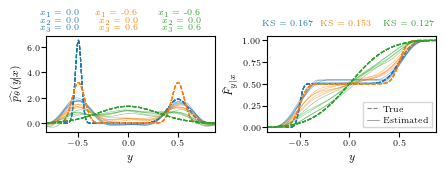

In [30]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = [[0.0, -0.6, -0.6], [0.0, 0.0, 0.0], [0.0, 0.6, 0.6]]
p1, p99 = np.percentile(Y_train, [0.5, 99.5])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = from_np(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.5,1.5))
axes = ax.flatten()
postprocess = 'whitening'

models = [torch.load('models/NCP_LGGMD_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
KS = np.zeros((len(x_grid),len(models)))
for i, xi in enumerate(x_grid):
    xi = list(xi) + [0]*17          # fill all other dimensions by 0
    xi = np.array(xi)
    xi_scaled = xscaler.transform(xi.reshape(1, -1))
    for j, model in enumerate(models):
        fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
        fys = fys.reshape(-1, 1)
        fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()
        true_pdf = density.pdf(xi, fys)

        axes[0].plot(fys, true_pdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[0].plot(fys, pred_pdf.squeeze()/yscaler.scale_, color=colours[i],linewidth=0.5, alpha=0.5)

        pred_cdf = integrate_pdf(pred_pdf, ys)
        true_cdf = density.cdf(xi, fys)

        axes[1].plot(fys, true_cdf, color=colours[i], linewidth=0.8, linestyle='--')
        axes[1].plot(fys, smooth_cdf(fys, pred_cdf), color=colours[i], linewidth=0.5, alpha=0.5)

        KS[i,j] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

KS = KS.mean(axis=1)
y_pos = axes[0].get_ylim()[1] +0.3
x_pos = np.array([.18, .31, .45])

for i in range(len(x_grid)):
    fig.text(x_pos[i], 0.95, r'$x_3$ = {0:.1f}'.format(x_grid[2][i]), ha="right", va="bottom", size=6,color=colours[i])
    fig.text(x_pos[i], 1.00, r'$x_2$ = {0:.1f}'.format(x_grid[1][i]), ha="right", va="bottom", size=6,color=colours[i])
    fig.text(x_pos[i], 1.05, r'$x_1$ = {0:.1f}'.format(x_grid[0][i]), ha="right", va="bottom", size=6,color=colours[i])

y_pos = axes[1].get_ylim()[1] +0.1
for i in range(len(x_grid)):
    fig.text(x_pos[i]+0.52, 0.98, r'KS = {0:.3f}'.format(KS[i]), ha="right", va="bottom", size=6,color=colours[i])

axes[0].set_xmargin(0)
axes[0].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
axes[0].set_xlabel("$y$")
axes[0].tick_params(axis="x", pad=2, labelsize=6)
axes[0].tick_params(axis="y", pad=1, labelsize=6)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].set_xmargin(0)
axes[1].set_ylabel(r"$\widehat{F}_{y|x}$")
axes[1].set_xlabel("$y$")
axes[1].tick_params(axis="x", pad=2, labelsize=6)
axes[1].tick_params(axis="y", pad=1, labelsize=6)

custom_lines = [Line2D([0], [0], color = 'gray', linewidth=0.8, linestyle='--'),
                Line2D([0], [0], color = 'gray', linewidth=0.5)]

labels = ['True', 'Estimated']

axes[1].legend(custom_lines, labels, loc='lower right', fancybox=False, handlelength=1.5, handletextpad=0.5, fontsize=6)

plt.tight_layout()
plt.show()

## Generating Figure 4

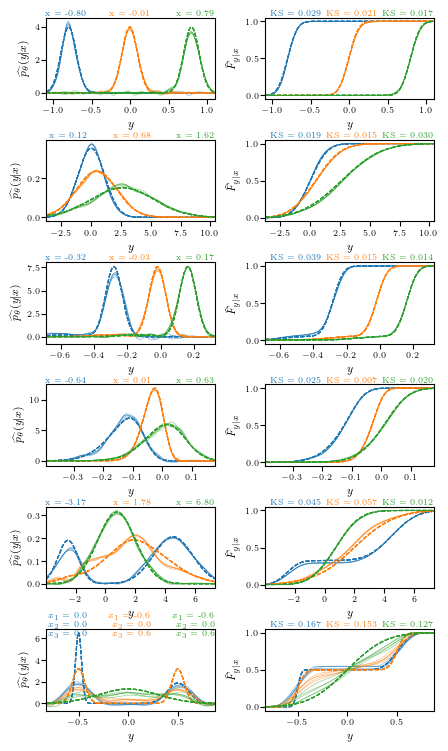

In [31]:
postprocess = 'whitening'
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(5,9))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
axs = ax.flatten()

densities = [LinearGaussian(ndim_x= 1, std= 0.1, random_seed= 42),
             EconDensity(std= 1, heteroscedastic=True, random_seed=42),
             ArmaJump(random_seed=42),
             SkewNormal(random_seed=0),
             GaussianMixture(ndim_x=1, ndim_y=1, means_std=3, random_seed=42),
             LGGMD(random_seed=42)]

densities_labels = ['LG', 'ECON', 'ARMA', 'SKEW', 'GMM', 'LGGMD']
for i, density in enumerate(densities):
    # if i > 1:
    #     continue
    X, Y = density.simulate(n_samples=int(1e5) + Nval)
    if X.ndim == 1:
        X = X.reshape((-1, 1))
        Y = Y.reshape((-1, 1))
    X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train = xscaler.fit_transform(X_train)
    Y_train = yscaler.fit_transform(Y_train)

    if densities_labels[i] == 'LGGMD':
        x_grid = [[0.0, -0.6, -0.6], [0.0, 0.0, 0.0], [0.0, 0.6, 0.6]]
    else:
        x_grid = np.percentile(X_train, [10, 50, 90])
    p1, p99 = np.percentile(Y_train, [0.5, 99.5])
    ys, step = np.linspace(p1, p99, num=1000, retstep=True)
    ys = from_np(ys.reshape(-1, 1))
    p_y = compute_marginal(bandwidth='scott').fit(Y_train)

    models = [torch.load('models/NCP_'+densities_labels[i]+'_{0}.pt'.format(seed)).to('cpu') for seed in range(5)]

    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    KS = np.zeros((len(x_grid),len(models)))
    for j, xi in enumerate(x_grid):
        for k, model in enumerate(models):
            if densities_labels[i] == 'LGGMD':
                fys, pred_pdf = model.pdf(from_np(np.array(list(xi) + [0] * 17).reshape(1, -1)), from_np(ys), postprocess=postprocess, p_y=p_y)
                fys = fys.reshape(-1, 1)
                fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()
                true_pdf = density.pdf(np.array(list(xi) + [0]*17).reshape(1,-1), fys)

                axs[i*2].plot(fys, true_pdf, color=colours[j], linewidth=0.8, linestyle='--')
                axs[i*2].plot(fys, pred_pdf.squeeze()/yscaler.scale_, color=colours[j],linewidth=0.5, alpha=0.5)

                pred_cdf = integrate_pdf(pred_pdf, ys)
                true_cdf = density.cdf(np.array(list(xi) + [0]*17).reshape(1,-1), fys)

                axs[i*2+1].plot(fys, true_cdf, color=colours[j], linewidth=0.8, linestyle='--')
                axs[i*2+1].plot(fys, smooth_cdf(fys, pred_cdf), color=colours[j], linewidth=0.5, alpha=0.5)

                KS[j,k] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

            else:
                xi = xi.reshape(1, -1)
                fys, pred_pdf = model.pdf(from_np([[xi]]), from_np(ys), postprocess=postprocess, p_y=p_y)
                fys = fys.reshape(-1, 1)
                true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                                       yscaler.inverse_transform(ys)).squeeze()
                axs[i*2].plot(yscaler.inverse_transform(fys), true_pdf, color=colours[j], linewidth=0.8, linestyle='--')
                axs[i*2].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_, color=colours[j],linewidth=0.5, alpha=0.5)

                pred_cdf = integrate_pdf(pred_pdf, ys)
                true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                                       yscaler.inverse_transform(ys)).squeeze()
                axs[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf, color=colours[j], linewidth=0.8, linestyle='--')
                axs[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf), color=colours[j], linewidth=0.5, alpha=0.5)

                KS[j,k] = kolmogorov_smirnov(true_cdf, pred_cdf, fys)

    axs[i*2].set_xmargin(0)
    axs[i*2].set_ylabel(r"$\widehat{p_{\theta}}(y|x)$")
    axs[i*2].set_xlabel("$y$")
    axs[i*2].tick_params(axis="x", pad=2, labelsize=6)
    axs[i*2].tick_params(axis="y", pad=1, labelsize=6)

    axs[i*2+1].set_xmargin(0)
    axs[i*2+1].set_ylabel(r"$\widehat{F}_{y|x}$")
    axs[i*2+1].set_xlabel("$y$")
    axs[i*2+1].tick_params(axis="x", pad=2, labelsize=6)
    axs[i*2+1].tick_params(axis="y", pad=1, labelsize=6)

    KS = KS.mean(axis=1)
    ax_pos = axs[i*2].get_position()
    x_pos = np.linspace(ax_pos.x0 * 1.65, ax_pos.x1, 3)
    y_pos = ax_pos.y1 + 0.001
    if densities_labels[i] == 'LGGMD':
        for j in range(len(x_grid)):
            fig.text(x_pos[j], y_pos-0.01, r'$x_3$ = {0:.1f}'.format(x_grid[2][j]), ha="right", va="bottom", size=6,color=colours[j])
            fig.text(x_pos[j], y_pos, r'$x_2$ = {0:.1f}'.format(x_grid[1][j]), ha="right", va="bottom", size=6,color=colours[j])
            fig.text(x_pos[j], y_pos+0.01, r'$x_1$ = {0:.1f}'.format(x_grid[0][j]), ha="right", va="bottom", size=6,color=colours[j])
    else:
        x_transformed = xscaler.inverse_transform(x_grid.reshape(-1, 1)).squeeze()
        for j in range(len(x_grid)):
            fig.text(x_pos[j], y_pos, r'x = {0:.2f}'.format(x_transformed[j]), ha="right", va="bottom", size=6, color=colours[j])

    ax_pos = axs[i*2+1].get_position()
    x_pos = np.linspace(ax_pos.x0 * 1.2, ax_pos.x1, 3)
    y_pos = ax_pos.y1 + 0.001
    for j in range(len(x_grid)):
        fig.text(x_pos[j], y_pos, r'KS = {0:.3f}'.format(KS[j]), ha="right", va="bottom",size=6, color=colours[j])

plt.show()